# Задание 2.1 - Нейронные сети

В этом задании вы реализуете и натренируете настоящую нейроную сеть своими руками!

В некотором смысле это будет расширением прошлого задания - нам нужно просто составить несколько линейных классификаторов вместе!

<img src="https://i.redd.it/n9fgba8b0qr01.png" alt="Stack_more_layers" width="400px"/>

In [1]:
# Запустите эту ячейку если работаете в Colab
!git clone https://github.com/ArseniyZu/Homework-ML_AM18-1.git
%cd Homework-ML_AM18-1/data
! wget -c http://ufldl.stanford.edu/housenumbers/train_32x32.mat http://ufldl.stanford.edu/housenumbers/test_32x32.mat
%cd ../DZ3

Cloning into 'Homework-ML_AM18-1'...
remote: Enumerating objects: 50, done.
remote: Counting objects: 100% (50/50), done.
remote: Compressing objects: 100% (45/45), done.
remote: Total 50 (delta 7), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (50/50), done.
/content/Homework-ML_AM18-1/data
--2021-03-18 16:13:59--  http://ufldl.stanford.edu/housenumbers/train_32x32.mat
Resolving ufldl.stanford.edu (ufldl.stanford.edu)... 171.64.68.10
Connecting to ufldl.stanford.edu (ufldl.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 182040794 (174M) [text/plain]
Saving to: ‘train_32x32.mat’

train_32x32.mat     100%[===================>] 173.61M  71.9MB/s    in 2.4s    

2021-03-18 16:14:02 (71.9 MB/s) - ‘train_32x32.mat’ saved [182040794/182040794]

--2021-03-18 16:14:02--  http://ufldl.stanford.edu/housenumbers/test_32x32.mat
Reusing existing connection to ufldl.stanford.edu:80.
HTTP request sent, awaiting response... 200 OK
Length:

In [2]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

%load_ext autoreload
%autoreload 2

In [3]:
from dataset import load_svhn, random_split_train_val
from gradient_check import check_layer_gradient, check_layer_param_gradient, check_model_gradient
from layers import FullyConnectedLayer, ReLULayer
from model import TwoLayerNet
from trainer import Trainer, Dataset
from optim import SGD, MomentumSGD
from metrics import multiclass_accuracy

# Загружаем данные

И разделяем их на training и validation.

In [4]:
def prepare_for_neural_network(train_X, test_X):
    train_flat = train_X.reshape(train_X.shape[0], -1).astype(np.float) / 255.0
    test_flat = test_X.reshape(test_X.shape[0], -1).astype(np.float) / 255.0
    
    # Subtract mean
    mean_image = np.mean(train_flat, axis = 0)
    train_flat -= mean_image
    test_flat -= mean_image
    
    return train_flat, test_flat
    
train_X, train_y, test_X, test_y = load_svhn("../data", max_train=10000, max_test=1000)    

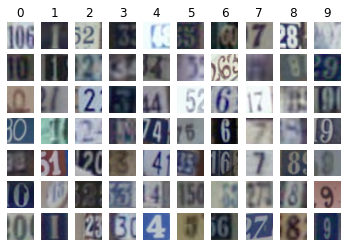

In [5]:
# Перед началом работы полезно посмотреть на данные.
# Отобразим пример из каждого класса.
classes = [str(i) for i in range(10)]
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(train_y == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(train_X[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [6]:
train_X, test_X = prepare_for_neural_network(train_X, test_X)
# Split train into train and val
train_X, train_y, val_X, val_y = random_split_train_val(train_X, train_y, num_val = 1000)

# Как всегда, начинаем с кирпичиков

Мы будем реализовывать необходимые нам слои по очереди. Каждый слой должен реализовать:
- прямой проход (forward pass), который генерирует выход слоя по входу и запоминает необходимые данные
- обратный проход (backward pass), который получает градиент по выходу слоя и вычисляет градиент по входу и по параметрам

Начнем с ReLU, у которого параметров нет.

In [7]:
# TODO: Implement ReLULayer layer in layers.py
# Note: you'll need to copy implementation of the gradient_check function from the previous assignment

X = np.array([[1,-2,3],
              [-1, 2, 0.1]
              ])

assert check_layer_gradient(ReLULayer(), X)

1.6159940625632276 1.6159940625648515
0.0 0.0
2.7625252407895857 2.7625252407403873
-0.0 0.0
-0.5060347044691067 -0.506034704450542
-0.9430251923423104 -0.9430251923348009
Gradient check passed!


А теперь реализуем полносвязный слой (fully connected layer), у которого будет два массива параметров: W (weights) и B (bias).

Все параметры наши слои будут использовать для параметров специальный класс `Param`, в котором будут храниться значения параметров и градиенты этих параметров, вычисляемые во время обратного прохода.

Это даст возможность аккумулировать (суммировать) градиенты из разных частей функции потерь, например, из cross-entropy loss и regularization loss.

In [8]:
# TODO: Implement FullyConnected layer forward and backward methods
assert check_layer_gradient(FullyConnectedLayer(3, 4), X)
# TODO: Implement storing gradients for W and B
assert check_layer_param_gradient(FullyConnectedLayer(3, 4), X, 'W')
assert check_layer_param_gradient(FullyConnectedLayer(3, 4), X, 'B')

0.00041894809483629007 0.0004189480948355722
0.0017633776701492833 0.0017633776701417995
-0.0003499794108387513 -0.0003499794108165199
7.827474122159668e-05 7.82747412025886e-05
-0.000612293143427732 -0.0006122931434007078
-0.0010994667536866132 -0.001099466753707798
Gradient check passed!
-1.6742936540026396 -1.6742936540024496
2.1531871835722116 2.1531871835723386
-0.15893915705062267 -0.1589391570506679
-0.5695817266487463 -0.5695817266488864
3.3485873080052793 3.3485873080050728
-4.306374367144423 -4.306374367144504
0.31787831410124534 0.31787831410116235
1.1391634532974926 1.139163453297426
-0.3625812156604907 -0.36258121566042767
5.458420182865275 5.458420182865263
-3.3777345903380063 -3.377734590338105
-0.8933996664600199 -0.8933996664600706
Gradient check passed!
-0.632844000634635 -0.6328440006347219
-0.3900283198139658 -0.3900283198139675
1.7534099466422033 1.753409946642255
0.510813659702079 0.5108136597021216
Gradient check passed!


## Создаем нейронную сеть

Теперь мы реализуем простейшую нейронную сеть с двумя полносвязным слоями и нелинейностью ReLU. Реализуйте функцию `compute_loss_and_gradients`, она должна запустить прямой и обратный проход через оба слоя для вычисления градиентов.

Не забудьте реализовать очистку градиентов в начале функции.

In [9]:
# TODO: In model.py, implement compute_loss_and_gradients function
model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 3, reg = 0)
loss = model.compute_loss_and_gradients(train_X[:2], train_y[:2])

# TODO Now implement backward pass and aggregate all of the params
check_model_gradient(model, train_X[:2], train_y[:2])

Выходные данные были обрезаны до нескольких последних строк (5000).
-3.833612036747935e-05 -3.833611206260912e-05
0.0 0.0
8.581846677818965e-05 8.581846344668519e-05
-3.216159616791801e-05 -3.216158450669582e-05
0.0 0.0
0.000104652500072318 0.00010465250888103127
1.2147117497724746e-05 1.2147105543647284e-05
0.0 0.0
0.00014939660636128629 0.00014939658399271138
-3.902494049814797e-05 -3.902496104046804e-05
0.0 0.0
7.922541676810743e-05 7.92254262194092e-05
-3.4790029233488626e-05 -3.4790037517495875e-05
0.0 0.0
9.387593772299374e-05 9.387592925236275e-05
5.677384670733197e-06 5.67741409440714e-06
0.0 0.0
0.00014338483473495562 0.00014338485954112912
-3.934167475466076e-05 -3.934168546493311e-05
0.0 0.0
4.202257615883305e-05 4.202256320695596e-05
-3.7128891336390595e-05 -3.7128877750092215e-05
0.0 0.0
5.241291069582626e-05 5.2412918449817873e-05
4.497575190975172e-06 4.497557881677494e-06
0.0 0.0
0.00010657060946442002 0.00010657059679175517
-3.6768593306734435e-05 -3.676861037860135e-0

True

Теперь добавьте к модели регуляризацию - она должна прибавляться к loss и делать свой вклад в градиенты.

In [10]:
# TODO Now implement l2 regularization in the forward and backward pass
model_with_reg = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 3, reg = 1e1)
loss_with_reg = model_with_reg.compute_loss_and_gradients(train_X[:2], train_y[:2])
assert loss_with_reg > loss and not np.isclose(loss_with_reg, loss), \
    "Loss with regularization (%2.4f) should be higher than without it (%2.4f)!" % (loss, loss_with_reg)

check_model_gradient(model_with_reg, train_X[:2], train_y[:2])

Выходные данные были обрезаны до нескольких последних строк (5000).
0.0010353517925000058 0.0010353517820860247
0.026418678840636953 0.026418678822359706
0.018409238936333592 0.018409238933259076
0.012044782902658282 0.01204478290439681
-0.013419705825937931 -0.013419705813255687
0.0046380838529174045 0.004638083850316832
-0.012308284952195216 -0.012308284946804802
0.024851427094308067 0.024851427093963704
-0.014321891801852553 -0.014321891805835206
-0.0026902136587864355 -0.0026902136518458515
-0.021544170540957426 -0.021544170536458292
-0.009891243227004133 -0.009891243224480206
-0.01018859451306719 -0.010188594523619088
-0.0028384614592181154 -0.0028384614658705227
-0.01792887039630505 -0.017928870410521824
0.02431257384898161 0.02431257384305496
-0.0034651207004883877 -0.003465120701484636
-0.010682782336597264 -0.010682782347615214
0.015393734871240254 0.01539373486458828
0.04336630425151593 0.04336630423651399
-0.008012679841398716 -0.008012679852953397
-0.004903083682454538 -0.0

True

Также реализуем функцию предсказания (вычисления значения) модели на новых данных.

Какое значение точности мы ожидаем увидеть до начала тренировки?

In [11]:
# Finally, implement predict function!

# TODO: Implement predict function
# What would be the value we expect?
multiclass_accuracy(model_with_reg.predict(train_X[:30]), train_y[:30]) 

0.1

# Допишем код для процесса тренировки

Если все реализовано корректно, значение функции ошибки должно уменьшаться в некоторых эпохах. Не беспокойтесь пока про validation accuracy.

In [14]:
model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 100, reg = 1)
dataset = Dataset(train_X, train_y, val_X, val_y)
trainer = Trainer(model, dataset, SGD(), learning_rate = 1e-2)

# TODO Implement missing pieces in Trainer.fit function
# You should expect loss to go down every epoch, even if it's slow
loss_history, train_history, val_history = trainer.fit()

Loss: 2.301911, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.295469, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.304003, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.299048, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.292701, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.297135, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.295198, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.301348, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.295351, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.304770, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.296425, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.302425, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.301573, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.283419, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.302790, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.294964, Train acc

# Улучшаем процесс тренировки

Мы реализуем несколько ключевых оптимизаций, необходимых для тренировки современных нейросетей.

## Уменьшение скорости обучения (learning rate decay)

Одна из необходимых оптимизаций во время тренировки нейронных сетей - постепенное уменьшение скорости обучения по мере тренировки.

Один из стандартных методов - уменьшение скорости обучения (learning rate) каждые N эпох на коэффициент d (часто называемый decay). Значения N и d, как всегда, являются гиперпараметрами и должны подбираться на основе эффективности на проверочных данных (validation data). 

В нашем случае N будет равным 1.

In [17]:
# TODO Implement learning rate decay inside Trainer.fit method
# Decay should happen once per epoch

model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 100, reg = 1e-1)
dataset = Dataset(train_X, train_y, val_X, val_y)
trainer = Trainer(model, dataset, SGD(), learning_rate_decay=0.99)

initial_learning_rate = trainer.learning_rate
loss_history, train_history, val_history = trainer.fit()

assert trainer.learning_rate < initial_learning_rate, "Learning rate should've been reduced"
assert trainer.learning_rate > 0.5*initial_learning_rate, "Learning rate shouldn'tve been reduced that much!"

Loss: 2.268617, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.281781, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.311644, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.289582, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.252788, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.315355, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.288743, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.259633, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.253962, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.279195, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.290681, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.335191, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.266479, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.357714, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.173243, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.237366, Train acc

# Накопление импульса (Momentum SGD)

Другой большой класс оптимизаций - использование более эффективных методов градиентного спуска. Мы реализуем один из них - накопление импульса (Momentum SGD).

Этот метод хранит скорость движения, использует градиент для ее изменения на каждом шаге, и изменяет веса пропорционально значению скорости.
(Физическая аналогия: Вместо скорости градиенты теперь будут задавать ускорение, но будет присутствовать сила трения.)

```
velocity = momentum * velocity - learning_rate * gradient 
w = w + velocity
```

`momentum` здесь коэффициент затухания, который тоже является гиперпараметром (к счастью, для него часто есть хорошее значение по умолчанию, типичный диапазон -- 0.8-0.99).

Несколько полезных ссылок, где метод разбирается более подробно:  
http://cs231n.github.io/neural-networks-3/#sgd  
https://distill.pub/2017/momentum/

In [18]:
# TODO: Implement MomentumSGD.update function in optim.py

model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 100, reg = 1e-1)
dataset = Dataset(train_X, train_y, val_X, val_y)
trainer = Trainer(model, dataset, MomentumSGD(), learning_rate=1e-4, learning_rate_decay=0.99)

# You should see even better results than before!
loss_history, train_history, val_history = trainer.fit()

Loss: 2.321785, Train accuracy: 0.196667, val accuracy: 0.206000


/content/Homework-ML_AM18-1/DZ3/layers.py:73: RuntimeWarning: divide by zero encountered in log
  loss = - 1 / N * np.sum(np.log(p_pred))


Loss: inf, Train accuracy: 0.073111, val accuracy: 0.073000
Loss: 360.998618, Train accuracy: 0.150556, val accuracy: 0.156000
Loss: 2.252525, Train accuracy: 0.153667, val accuracy: 0.148000
Loss: 2.340841, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.208212, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.224853, Train accuracy: 0.161000, val accuracy: 0.144000
Loss: 2.298878, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.326255, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.283018, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.310815, Train accuracy: 0.196222, val accuracy: 0.205000
Loss: 2.301167, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.288571, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.234028, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.338831, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.358396, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.279416, Train accura

# Ну что, давайте уже тренировать сеть!

## Последний тест - переобучимся (overfit) на маленьком наборе данных

Хороший способ проверить, все ли реализовано корректно - переобучить сеть на маленьком наборе данных.  
Наша модель обладает достаточной мощностью, чтобы приблизить маленький набор данных идеально, поэтому мы ожидаем, что на нем мы быстро дойдем до 100% точности на тренировочном наборе. 

Если этого не происходит, то где-то была допущена ошибка!

In [19]:
data_size = 15
model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 100, reg = 1e-1)
dataset = Dataset(train_X[:data_size], train_y[:data_size], val_X[:data_size], val_y[:data_size])
trainer = Trainer(model, dataset, SGD(), learning_rate=1e-1, num_epochs=150, batch_size=5)

# You should expect this to reach 1.0 training accuracy 
loss_history, train_history, val_history = trainer.fit()

Loss: 2.334890, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.312070, Train accuracy: 0.266667, val accuracy: 0.066667
Loss: 2.310056, Train accuracy: 0.333333, val accuracy: 0.066667
Loss: 2.316334, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.291100, Train accuracy: 0.266667, val accuracy: 0.000000
Loss: 2.318675, Train accuracy: 0.266667, val accuracy: 0.000000
Loss: 2.371569, Train accuracy: 0.266667, val accuracy: 0.000000
Loss: 2.253239, Train accuracy: 0.266667, val accuracy: 0.000000
Loss: 2.360868, Train accuracy: 0.266667, val accuracy: 0.000000
Loss: 2.121049, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 1.959724, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 1.891919, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 1.851469, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 2.280141, Train accuracy: 0.333333, val accuracy: 0.000000
Loss: 1.516065, Train accuracy: 0.333333, val accuracy: 0.000000
Loss: 1.653346, Train acc

Теперь найдем гипепараметры, для которых этот процесс сходится быстрее.
Если все реализовано корректно, то существуют параметры, при которых процесс сходится в **20** эпох или еще быстрее.
Найдите их!

In [20]:
# Now, tweak some hyper parameters and make it train to 1.0 accuracy in 20 epochs or less

model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 100, reg = 1e-1)
dataset = Dataset(train_X[:data_size], train_y[:data_size], val_X[:data_size], val_y[:data_size])
# TODO: Change any hyperparamers or optimizators to reach training accuracy in 20 epochs
trainer = Trainer(model, dataset, SGD(), learning_rate=1e-1, num_epochs=20, batch_size=5)

loss_history, train_history, val_history = trainer.fit()

Loss: 2.330659, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.327269, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.296078, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.300452, Train accuracy: 0.266667, val accuracy: 0.066667
Loss: 2.303707, Train accuracy: 0.266667, val accuracy: 0.000000
Loss: 2.318303, Train accuracy: 0.266667, val accuracy: 0.000000
Loss: 2.257127, Train accuracy: 0.266667, val accuracy: 0.000000
Loss: 2.231068, Train accuracy: 0.266667, val accuracy: 0.000000
Loss: 2.254753, Train accuracy: 0.333333, val accuracy: 0.000000
Loss: 2.062892, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 2.242030, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 1.820680, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 2.091898, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 2.070133, Train accuracy: 0.333333, val accuracy: 0.000000
Loss: 2.383931, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 1.913772, Train acc

# Итак, основное мероприятие!

Натренируйте лучшую нейросеть! Можно добавлять и изменять параметры, менять количество нейронов в слоях сети и как угодно экспериментировать. 

Добейтесь точности лучше **60%** на validation set.

In [26]:
# Let's train the best one-hidden-layer network we can

learning_rate = 1e-4
reg_strength = 1e-3
learning_rate_decay = 0.999
hidden_layer_size = 128
num_epochs = 200
batch_size = 64

best_classifier = None
best_val_accuracy = None

loss_history = []
train_history = []
val_history = []

# TODO find the best hyperparameters to train the network
# Don't hesitate to add new values to the arrays above, perform experiments, use any tricks you want
# You should expect to get to at least 40% of valudation accuracy
# Save loss/train/history of the best classifier to the variables above
model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = hidden_layer_size, reg = reg_strength)
dataset = Dataset(train_X, train_y, val_X, val_y)
trainer = Trainer(model, dataset, MomentumSGD(), num_epochs=num_epochs,
                  batch_size=batch_size, learning_rate=learning_rate, learning_rate_decay = learning_rate_decay)

loss, train, val = trainer.fit()
loss_history.append(loss)
train_history.append(train)
val_history.append(val)
best_val_accuracy = max(val_history)

print('best validation accuracy achieved: %f' % max(best_val_accuracy))
assert max(best_val_accuracy) > 0.6, "Accuracy wasn't achieved"
best_classifier = model

Loss: 2.301748, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.168964, Train accuracy: 0.319333, val accuracy: 0.313000
Loss: 1.261032, Train accuracy: 0.533889, val accuracy: 0.542000
Loss: 1.105902, Train accuracy: 0.656444, val accuracy: 0.640000
Loss: 1.232498, Train accuracy: 0.719333, val accuracy: 0.694000
Loss: 1.003482, Train accuracy: 0.743444, val accuracy: 0.698000
Loss: 1.146160, Train accuracy: 0.750556, val accuracy: 0.708000
Loss: 1.060986, Train accuracy: 0.768000, val accuracy: 0.706000
Loss: 1.190320, Train accuracy: 0.775333, val accuracy: 0.700000
Loss: 1.022954, Train accuracy: 0.791000, val accuracy: 0.736000
Loss: 0.932426, Train accuracy: 0.810111, val accuracy: 0.752000
Loss: 0.948796, Train accuracy: 0.824667, val accuracy: 0.742000
Loss: 0.887657, Train accuracy: 0.822667, val accuracy: 0.729000
Loss: 1.077155, Train accuracy: 0.836000, val accuracy: 0.750000
Loss: 0.796741, Train accuracy: 0.839778, val accuracy: 0.741000
Loss: 0.961615, Train acc

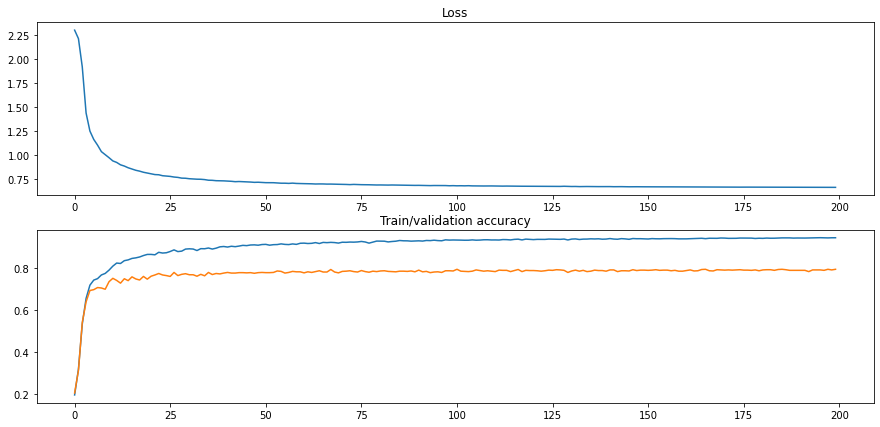

In [29]:
plt.figure(figsize=(15, 7))
plt.subplot(211)
plt.title("Loss")
plt.plot(loss_history[0])
plt.subplot(212)
plt.title("Train/validation accuracy")
plt.plot(train_history[0])
plt.plot(val_history[0])

# Как обычно, посмотрим, как наша лучшая модель работает на тестовых данных

In [30]:
test_pred = best_classifier.predict(test_X)
test_accuracy = multiclass_accuracy(test_pred, test_y)
print('Neural net test set accuracy: %f' % (test_accuracy, ))

Neural net test set accuracy: 0.766000
